In [1]:
import os
import math

import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn

from numpy import load
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from xgboost import XGBClassifier

from sklearn.impute import KNNImputer

from sklearn.svm import SVC

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

rd_seed = 333

## Načtení dat

In [2]:
path_file = os.sep.join(['created_data', 'matrix_bak_2015.csv'])
matrix_bak = pd.read_csv(path_file, sep=",")

## Info o datasetu

In [3]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3936 entries, 0 to 3935
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   studium_id              3936 non-null   int64  
 1   pohlavi_kod             3936 non-null   int64  
 2   je_cech                 3936 non-null   int64  
 3   datum_zahajeni          3936 non-null   int64  
 4   rok_maturity            3936 non-null   int64  
 5   maturita_nastup_rozdil  3936 non-null   int64  
 6   gymnazium               3936 non-null   int64  
 7   praha                   3936 non-null   int64  
 8   scio                    3936 non-null   int64  
 9   olym                    3936 non-null   int64  
 10  zkouska                 3936 non-null   int64  
 11  prominuti               3936 non-null   int64  
 12  dostudoval_uspesne      3936 non-null   int64  
 13  BI-PA1                  3866 non-null   float64
 14  BI-PAI                  3867 non-null   

In [4]:
matrix_bak.mean()

studium_id                1.450497e+07
pohlavi_kod               1.257622e-01
je_cech                   7.731199e-01
datum_zahajeni            2.017119e+03
rok_maturity              2.016279e+03
maturita_nastup_rozdil    8.394309e-01
gymnazium                 5.406504e-01
praha                     5.005081e-02
scio                      7.190041e-02
olym                      7.545732e-02
zkouska                   2.870935e-02
prominuti                 0.000000e+00
dostudoval_uspesne        2.113821e-01
BI-PA1                    3.204346e+00
BI-PAI                    2.759633e+00
BI-CAO                    2.005299e+00
BI-PS1                    3.077132e+00
BI-MLO                    3.005428e+00
BI-ZMA                    3.219130e+00
BI-PA2                    2.979326e+00
BI-DBS                    2.557846e+00
BI-SAP                    2.467303e+00
BI-LIN                    3.258693e+00
BI-AG1                    2.848361e+00
BI-AAG                    2.813123e+00
BI-ZDM                   

## Příprava datasetu

### Nastavení indexu

In [5]:
matrix_bak = matrix_bak.set_index(['studium_id'])

### Přidání příznaků

In [6]:
matrix_bak['prumer'] = matrix_bak.loc[:, 'BI-PA1':'BI-EMP'].mean(axis=1)

In [7]:
matrix_bak.mean()

pohlavi_kod                  0.125762
je_cech                      0.773120
datum_zahajeni            2017.118648
rok_maturity              2016.279217
maturita_nastup_rozdil       0.839431
gymnazium                    0.540650
praha                        0.050051
scio                         0.071900
olym                         0.075457
zkouska                      0.028709
prominuti                    0.000000
dostudoval_uspesne           0.211382
BI-PA1                       3.204346
BI-PAI                       2.759633
BI-CAO                       2.005299
BI-PS1                       3.077132
BI-MLO                       3.005428
BI-ZMA                       3.219130
BI-PA2                       2.979326
BI-DBS                       2.557846
BI-SAP                       2.467303
BI-LIN                       3.258693
BI-AG1                       2.848361
BI-AAG                       2.813123
BI-ZDM                       2.907979
BI-OSY                       2.721917
BI-PSI      

### Doplnění NaN hodnot

##### Doplnění pomocí KNNImputer

In [8]:
imputer = KNNImputer(n_neighbors=5, weights='distance')
matrix_bak = pd.DataFrame(imputer.fit_transform(matrix_bak), index=matrix_bak.index, columns=matrix_bak.columns)

In [9]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3936 entries, 12375406 to 11740806
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pohlavi_kod             3936 non-null   float64
 1   je_cech                 3936 non-null   float64
 2   datum_zahajeni          3936 non-null   float64
 3   rok_maturity            3936 non-null   float64
 4   maturita_nastup_rozdil  3936 non-null   float64
 5   gymnazium               3936 non-null   float64
 6   praha                   3936 non-null   float64
 7   scio                    3936 non-null   float64
 8   olym                    3936 non-null   float64
 9   zkouska                 3936 non-null   float64
 10  prominuti               3936 non-null   float64
 11  dostudoval_uspesne      3936 non-null   float64
 12  BI-PA1                  3936 non-null   float64
 13  BI-PAI                  3936 non-null   float64
 14  BI-CAO                  3936 

#### Zaokrouhlení doplněných hodnot

In [10]:
grades = [1, 1.5, 2, 2.5, 3, 4]

In [11]:
def custom_round(value):
    return min(grades, key=lambda x:abs(x-value))

In [12]:
matrix_bak.loc[:, 'BI-PA1':'BI-EMP'] = matrix_bak.loc[:, 'BI-PA1':'BI-EMP'].applymap(custom_round)

In [13]:
matrix_bak

pohlavi_kod  je_cech  datum_zahajeni  rok_maturity  \
studium_id                                                       
12375406            0.0      1.0          2015.0        2009.0   
11736906            0.0      1.0          2015.0        2009.0   
12032306            0.0      1.0          2015.0        2007.0   
15613006            0.0      1.0          2018.0        2009.0   
12948006            1.0      1.0          2016.0        2010.0   
11703806            0.0      1.0          2015.0        2010.0   
12967806            0.0      1.0          2016.0        2010.0   
11738606            0.0      0.0          2015.0        2010.0   
11719706            0.0      1.0          2015.0        2010.0   
11675306            0.0      0.0          2015.0        2010.0   
12987806            0.0      1.0          2016.0        2010.0   
11743906            0.0      1.0          2015.0        2010.0   
13016006            0.0      1.0          2016.0        2010.0   
12036006            0.0      1.0          2015.0        2010.0   
13512306            0.0      1.0          2016.0        2011.0   
12987706            0.0      1.0          2016.0        2010.0   
11678106            0.0      1.0          2015.0        2010.0   
13518506            0.0      1.0          2016.0        2011.0   
14256606            0.0      0.0          2017.0        2011.0   
11727206            0.0      1.0          2015.0        2011.0   
11736306            0.0      1.0          2015.0        2011.0   
12967906            0.0      1.0          2016.0        2011.0   
11703506            0.0      1.0          2015.0        2011.0   
13010106            0.0      1.0          2016.0        2011.0   
14800306            0.0      1.0          2017.0        2011.0   
11744706            1.0      1.0          2015.0        2011.0   
11696406            1.0      0.0          2015.0        2010.0   
12973406            0.0      1.0          2016.0        2011.0   
11737806            0.0      1.0          2015.0        2011.0   
12035506            1.0      0.0          2015.0        2011.0   
13512006            0.0      1.0          2016.0        2011.0   
12964406            0.0      1.0          2016.0        2011.0   
12994106            1.0      1.0          2016.0        2011.0   
11742506            0.0      1.0          2015.0        2011.0   
11712706            0.0      1.0          2015.0        2011.0   
13518806            0.0      1.0          2016.0        2011.0   
11735606            0.0      1.0          2015.0        2011.0   
13518606            0.0      1.0          2016.0        2011.0   
15586306            0.0      1.0          2018.0        2011.0   
13519806            0.0      1.0          2016.0        2011.0   
11686106            0.0      1.0          2015.0        2012.0   
11692606            0.0      1.0          2015.0        2012.0   
13013306            0.0      1.0          2016.0        2012.0   
11713906            0.0      1.0          2015.0        2012.0   
12978506            0.0      1.0          2016.0        2012.0   
14283706            0.0      1.0          2017.0        2012.0   
11736706            0.0      1.0          2015.0        2012.0   
11676006            0.0      1.0          2015.0        2012.0   
12033706            0.0      1.0          2015.0        2012.0   
12964506            0.0      1.0          2016.0        2012.0   
16724706            0.0      1.0          2019.0        2012.0   
12954706            0.0      1.0          2016.0        2012.0   
12034706            0.0      0.0          2015.0        2012.0   
12959206            0.0      1.0          2016.0        2012.0   
14803806            0.0      1.0          2017.0        2012.0   
11733706            0.0      1.0          2015.0        2012.0   
11707706            0.0      1.0          2015.0        2012.0   
12032006            0.0      1.0          2015.0        2012.0   
12997606            0.0      0.0          2016.0    

### Pomocné promenné

In [14]:
# predmety podle doporuceneho semestru
courses_1 = ['BI-PA1', 'BI-PAI', 'BI-CAO', 'BI-PS1', 'BI-MLO', 'BI-ZMA']
courses_2 = ['BI-PA2', 'BI-DBS', 'BI-SAP', 'BI-LIN']
courses_3 = ['BI-AAG', 'BI-ZDM', 'BI-AG1']
courses_4 = ['BI-OSY', 'BI-PSI', 'BI-BEZ']
courses_5 = ['BI-PST']
courses_6 = ['BI-DPR']
courses_7 = ['BI-SI1.2', 'BI-EMP']

courses = courses_1 + courses_2 + courses_3 + courses_4 + courses_5 + courses_6 + courses_7

In [15]:
means = {'BI-PA1':3, 'BI-PAI':3, 'BI-CAO':2, 'BI-PS1':3, 'BI-MLO':3, 'BI-ZMA':3,
        'BI-PA2':3, 'BI-DBS':2.5, 'BI-SAP':2.5, 'BI-LIN':3,
        'BI-AAG':3, 'BI-ZDM':3, 'BI-AG1':3,
        'BI-OSY':2.5, 'BI-PSI':2.5, 'BI-BEZ':2.5,
        'BI-PST':2,
        'BI-DPR':1.5,
        'BI-SI1.2':2, 'BI-EMP':2
        }

prumer_mean = 3

### Nastavení atributů na kategorické - ordinální

In [16]:
# ordinální
grades_category = pd.api.types.CategoricalDtype(categories=[1, 1.5, 2, 2.5, 3, 4, 0], ordered=True)
# BI-PA1
matrix_bak['BI-PA1'] = matrix_bak['BI-PA1'].astype(grades_category)
# BI-PAI
matrix_bak['BI-PAI'] = matrix_bak['BI-PAI'].astype(grades_category)
# BI-CAO
matrix_bak['BI-CAO'] = matrix_bak['BI-CAO'].astype(grades_category)
# BI-PS1
matrix_bak['BI-PS1'] = matrix_bak['BI-PS1'].astype(grades_category)
# BI-MLO
matrix_bak['BI-MLO'] = matrix_bak['BI-MLO'].astype(grades_category)
# BI-ZMA
matrix_bak['BI-ZMA'] = matrix_bak['BI-ZMA'].astype(grades_category)
# BI-PA2
matrix_bak['BI-PA2'] = matrix_bak['BI-PA2'].astype(grades_category)
# BI-DBS
matrix_bak['BI-DBS'] = matrix_bak['BI-DBS'].astype(grades_category)
# BI-SAP
matrix_bak['BI-SAP'] = matrix_bak['BI-SAP'].astype(grades_category)
# BI-LIN
matrix_bak['BI-LIN'] = matrix_bak['BI-LIN'].astype(grades_category)
# BI-AG1
matrix_bak['BI-AG1'] = matrix_bak['BI-AG1'].astype(grades_category)
# BI-AAG
matrix_bak['BI-AAG'] = matrix_bak['BI-AAG'].astype(grades_category)
# BI-ZDM
matrix_bak['BI-ZDM'] = matrix_bak['BI-ZDM'].astype(grades_category)
# BI-OSY
matrix_bak['BI-OSY'] = matrix_bak['BI-OSY'].astype(grades_category)
# BI-PSI
matrix_bak['BI-PSI'] = matrix_bak['BI-PSI'].astype(grades_category)
# BI-BEZ
matrix_bak['BI-BEZ'] = matrix_bak['BI-BEZ'].astype(grades_category)
# BI-PST
matrix_bak['BI-PST'] = matrix_bak['BI-PST'].astype(grades_category)
# BI-SI1.2
matrix_bak['BI-SI1.2'] = matrix_bak['BI-SI1.2'].astype(grades_category)
# BI-MLO
matrix_bak['BI-EMP'] = matrix_bak['BI-EMP'].astype(grades_category)
# BI-DPR
matrix_bak['BI-DPR'] = matrix_bak['BI-DPR'].astype(grades_category)

### Nastavení nepředmětových atributů na kategorické

In [17]:
# ordinální
attr_category = pd.api.types.CategoricalDtype(categories=[0, 1], ordered=False)
# pohlavi_kod
matrix_bak['pohlavi_kod'] = matrix_bak['pohlavi_kod'].astype(attr_category)
# scio
matrix_bak['scio'] = matrix_bak['scio'].astype(attr_category)
# olym
matrix_bak['olym'] = matrix_bak['olym'].astype(attr_category)
# zkouska
matrix_bak['zkouska'] = matrix_bak['zkouska'].astype(attr_category)
# prominuti
matrix_bak['prominuti'] = matrix_bak['prominuti'].astype(attr_category)

In [18]:
# ordinální
attr_category = pd.api.types.CategoricalDtype(categories=[-1, 0, 1], ordered=False)
# je_cech
matrix_bak['je_cech'] = matrix_bak['je_cech'].astype(attr_category)
# gymnazium
matrix_bak['gymnazium'] = matrix_bak['gymnazium'].astype(attr_category)
# praha
matrix_bak['praha'] = matrix_bak['praha'].astype(attr_category)

In [19]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3936 entries, 12375406 to 11740806
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   pohlavi_kod             3936 non-null   category
 1   je_cech                 3936 non-null   category
 2   datum_zahajeni          3936 non-null   float64 
 3   rok_maturity            3936 non-null   float64 
 4   maturita_nastup_rozdil  3936 non-null   float64 
 5   gymnazium               3936 non-null   category
 6   praha                   3936 non-null   category
 7   scio                    3936 non-null   category
 8   olym                    3936 non-null   category
 9   zkouska                 3936 non-null   category
 10  prominuti               3936 non-null   category
 11  dostudoval_uspesne      3936 non-null   float64 
 12  BI-PA1                  3936 non-null   category
 13  BI-PAI                  3936 non-null   category
 14  BI-CAO       

## Modelování

### Bakalář všechny pp

#### Rozdělení datasetu

In [20]:
Xdata = matrix_bak.drop(columns='dostudoval_uspesne')
ydata = matrix_bak.dostudoval_uspesne

In [21]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.2, random_state=rd_seed, stratify=ydata, shuffle=True) 
print("původní data")
display(Xdata.shape)
display(ydata.shape)
print("trénovací data")
display(Xtrain.shape)
display(ytrain.shape)
print("testovací data")
display(Xtest.shape)
display(ytest.shape)

původní data


(3936, 32)

(3936,)

trénovací data


(3148, 32)

(3148,)

testovací data


(788, 32)

(788,)

#### Funkce pro vybrání vhodných hyperparametrů pomocí křížové validace

In [22]:
def get_best_parameters(param_grid, classifier, xgb=None):
    score = 'f1'
    if xgb:
        model = GridSearchCV(classifier(eval_metric='mlogloss', use_label_encoder=False, tree_method="gpu_hist", enable_categorical=True), param_grid, cv=5, scoring=score)
    else:
        model = GridSearchCV(classifier(), param_grid, cv=5, scoring=score)
    model.fit(Xtrain, ytrain)

    print('Best hyper-parameters are: ')
    print(model.best_params_)
    print()

    means = model.cv_results_["mean_test_score"]
    stds = model.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, model.cv_results_["params"]):
        print("%0.6f (+/-%0.06f) for %r" % (mean, std * 2, params))
    print()
    return model

#### Rozhodovací strom

In [23]:
param_grid = [
    {'criterion':['gini','entropy'],
    'max_depth': range(2,7),
    'min_samples_leaf':[10]}
]

In [24]:
dt_f1 = get_best_parameters(param_grid, DecisionTreeClassifier)

Best hyper-parameters are: 
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10}

0.907704 (+/-0.035602) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10}
0.922998 (+/-0.014015) for {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10}
0.934882 (+/-0.028097) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10}
0.939349 (+/-0.016767) for {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}
0.937970 (+/-0.014174) for {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10}
0.908697 (+/-0.035367) for {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 10}
0.930686 (+/-0.025160) for {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10}
0.943336 (+/-0.021371) for {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 10}
0.946540 (+/-0.022159) for {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10}
0.949247 (+/-0.023229) for {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10}



In [25]:
ytrain

studium_id
11675606    1.0
12034606    0.0
18597306    0.0
17930506    0.0
14272406    0.0
12992006    1.0
12973306    0.0
12962706    1.0
17934606    0.0
13000506    1.0
14949106    0.0
14802806    0.0
12980406    1.0
13010806    0.0
15590406    1.0
11699606    0.0
15596106    1.0
13512606    0.0
12989606    1.0
11743706    0.0
17939606    0.0
11681106    0.0
13514206    0.0
14241506    0.0
15591406    0.0
11723606    0.0
13003606    1.0
16771606    0.0
15614106    1.0
11726506    0.0
14305306    0.0
15616706    0.0
17327106    0.0
11684106    1.0
14805106    0.0
13511306    1.0
14322606    0.0
12955706    1.0
14275106    1.0
11696506    0.0
11734006    0.0
14296506    1.0
18597406    0.0
11725406    1.0
11682406    0.0
16726506    0.0
12290006    1.0
13007906    0.0
14242606    0.0
14308906    1.0
11702806    0.0
11711006    0.0
16186206    0.0
15568106    1.0
11690206    0.0
11732806    0.0
15594806    1.0
15617206    0.0
12968206    1.0
15585806    0.0
15573806    1.0
15571106    0

In [26]:
dt_f1.predict(Xtrain)

array([1., 0., 0., ..., 0., 0., 0.])

In [27]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt_f1.predict(Xtest))))

accuracy score (train): 0.982211
accuracy score (test): 0.987310


In [28]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':dt_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

features  feature_importance
31                  prumer            0.799884
23                  BI-ZDM            0.068958
24                  BI-OSY            0.058283
21                  BI-AG1            0.032659
27                  BI-PST            0.025615
28                  BI-DPR            0.011710
22                  BI-AAG            0.001846
2           datum_zahajeni            0.001045
17                  BI-PA2            0.000000
30                  BI-EMP            0.000000
29                BI-SI1.2            0.000000
26                  BI-BEZ            0.000000
25                  BI-PSI            0.000000
20                  BI-LIN            0.000000
19                  BI-SAP            0.000000
18                  BI-DBS            0.000000
0              pohlavi_kod            0.000000
1                  je_cech            0.000000
15                  BI-MLO            0.000000
14                  BI-PS1            0.000000
13                  BI-CAO            0.000000
12                  BI-PAI            0.000000
11                  BI-PA1            0.000000
10               prominuti            0.000000
9                  zkouska            0.000000
8                     olym            0.000000
7                     scio            0.000000
6                    praha            0.000000
5                gymnazium            0.000000
4   maturita_nastup_rozdil            0.000000
3             rok_maturity            0.000000
16                  BI-ZMA            0.000000

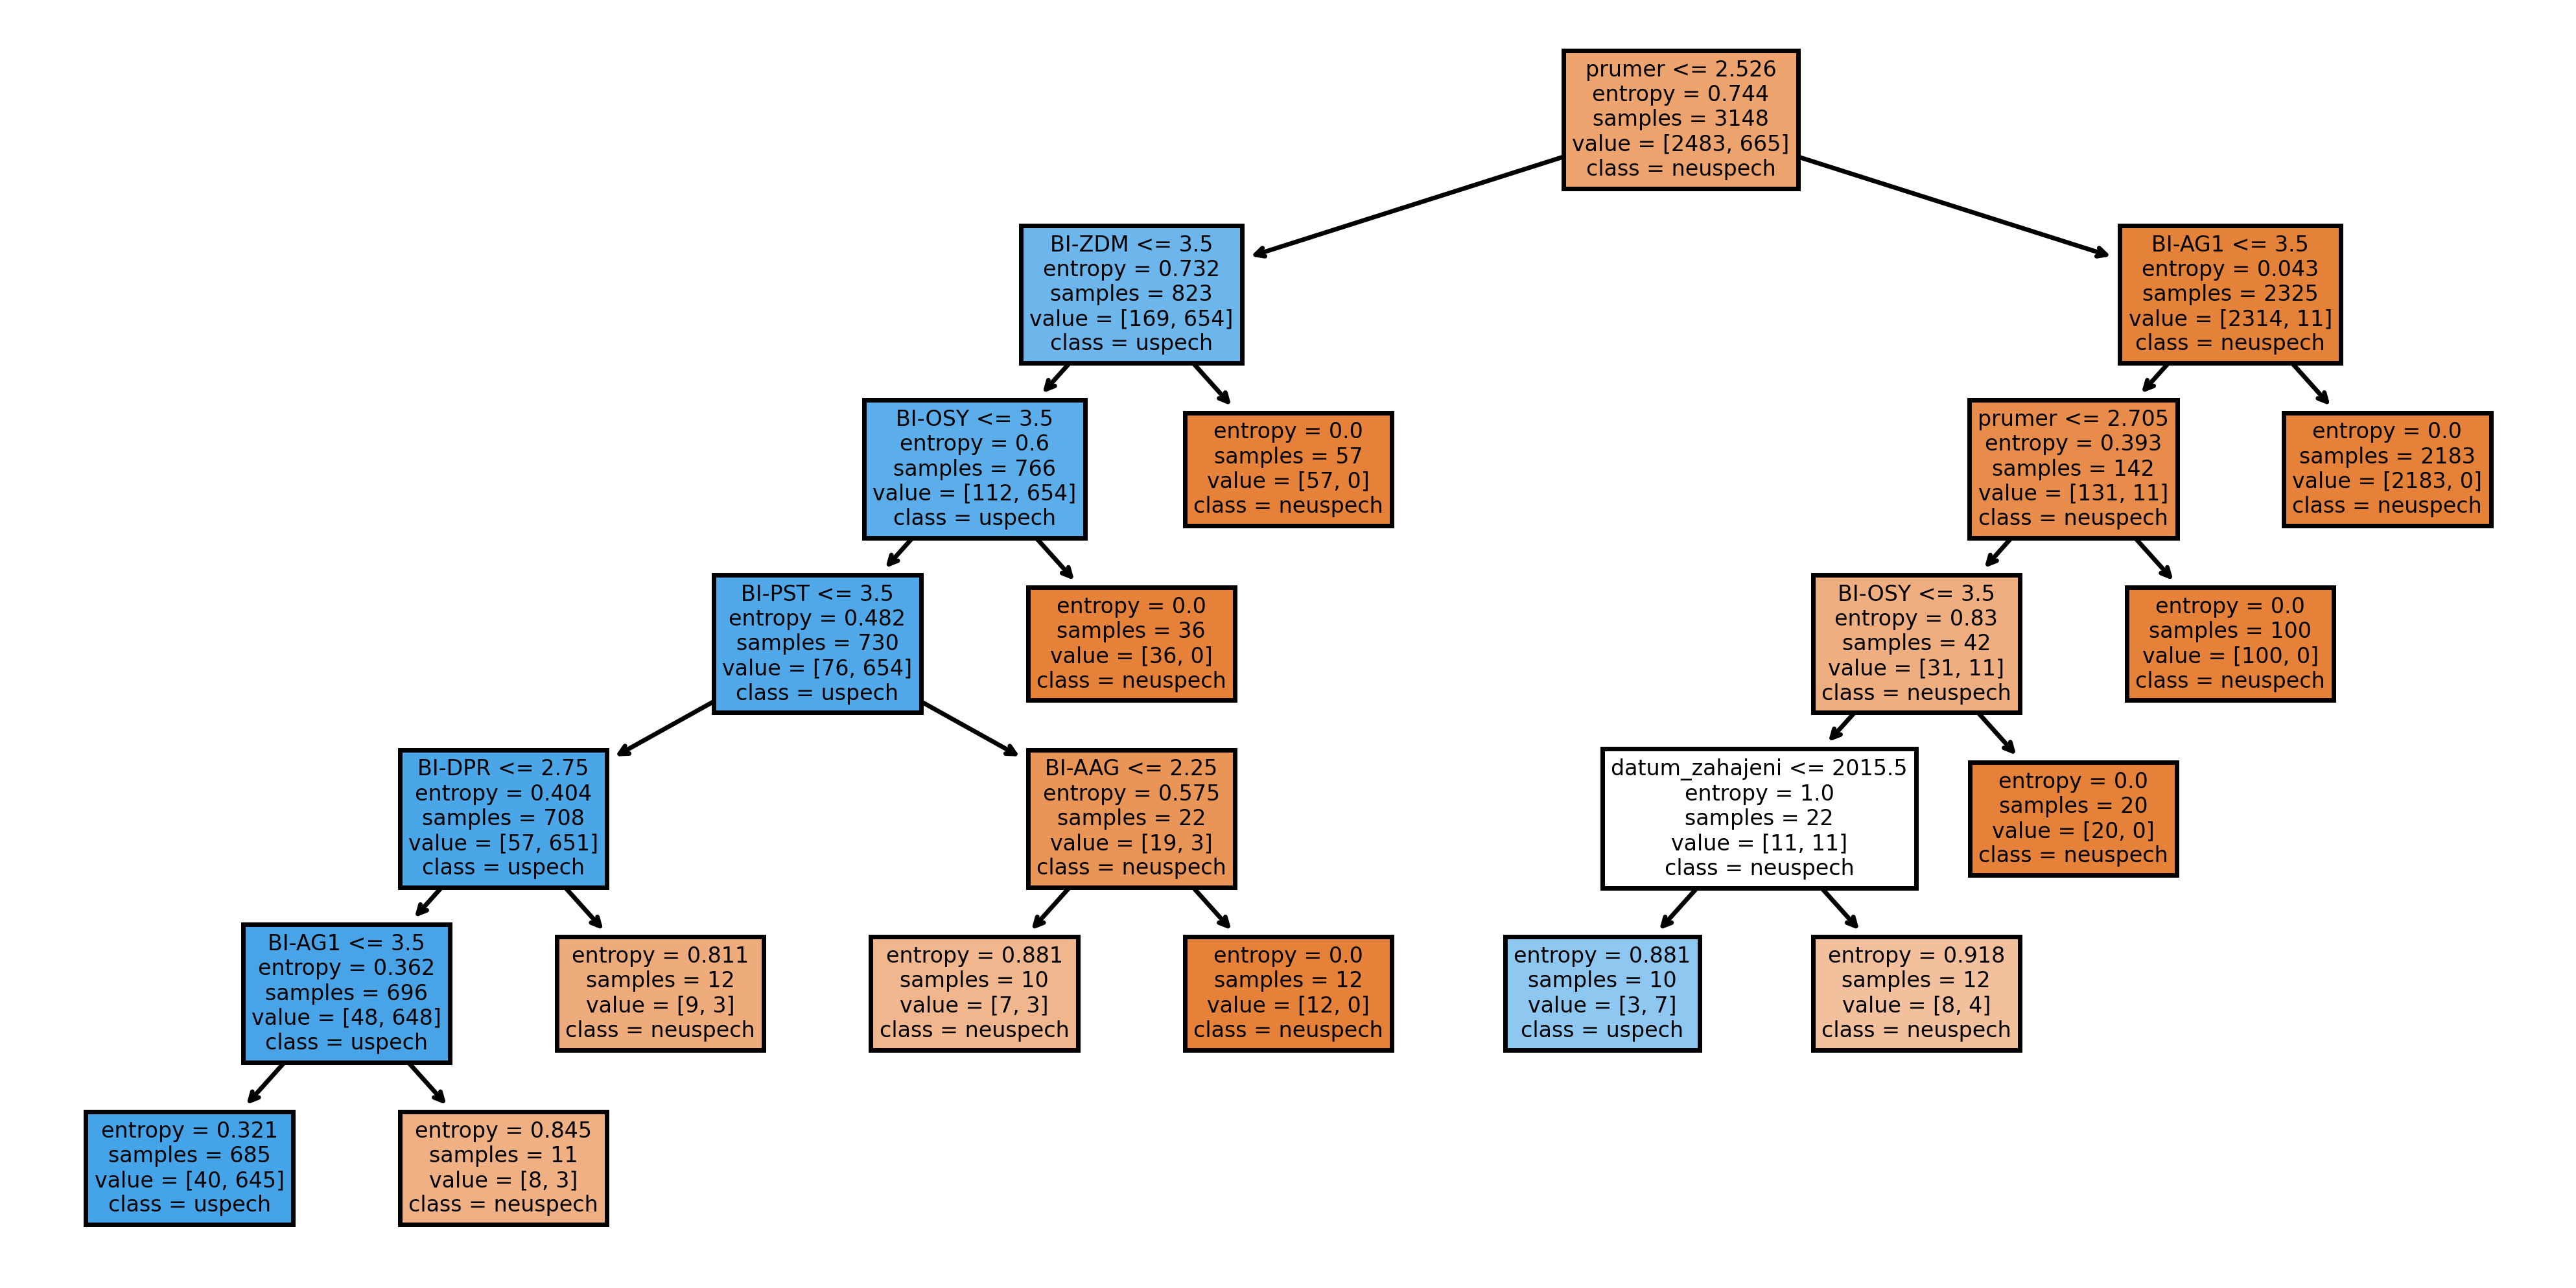

In [29]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5), dpi=500)
tree.plot_tree(dt_f1.best_estimator_,
               feature_names = Xdata.columns, 
               class_names=['neuspech', 'uspech'],
               filled = True);
fig.savefig('tree_f1.png')

#### Random forest

In [30]:
param_grid_rf = {
    'criterion':['gini','entropy'],
    'n_estimators': range(5, 50, 5),
    'max_depth': range(2, 4),
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf':[10]
}

In [31]:
rf_f1 = get_best_parameters(param_grid_rf, RandomForestClassifier)

Best hyper-parameters are: 
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 45}

0.916769 (+/-0.037951) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 5}
0.925226 (+/-0.029969) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 10}
0.915705 (+/-0.023643) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 15}
0.927709 (+/-0.032226) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 20}
0.930308 (+/-0.030343) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 25}
0.925677 (+/-0.027715) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 30}
0.923294 (+/-0.022814) for {'criterion': 'gini', 'max_depth': 2, 

In [32]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, rf_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, rf_f1.predict(Xtest))))

accuracy score (train): 0.975540
accuracy score (test): 0.983503


In [33]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':rf_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

features  feature_importance
31                  prumer            0.170177
22                  BI-AAG            0.156683
21                  BI-AG1            0.149628
20                  BI-LIN            0.111210
23                  BI-ZDM            0.093494
17                  BI-PA2            0.075181
26                  BI-BEZ            0.060953
24                  BI-OSY            0.053335
27                  BI-PST            0.047882
16                  BI-ZMA            0.028601
30                  BI-EMP            0.013525
14                  BI-PS1            0.009780
15                  BI-MLO            0.009426
25                  BI-PSI            0.005593
11                  BI-PA1            0.004934
28                  BI-DPR            0.003798
2           datum_zahajeni            0.001967
29                BI-SI1.2            0.001903
12                  BI-PAI            0.000816
19                  BI-SAP            0.000642
3             rok_maturity            0.000434
6                    praha            0.000036
10               prominuti            0.000000
4   maturita_nastup_rozdil            0.000000
7                     scio            0.000000
5                gymnazium            0.000000
8                     olym            0.000000
18                  BI-DBS            0.000000
9                  zkouska            0.000000
1                  je_cech            0.000000
13                  BI-CAO            0.000000
0              pohlavi_kod            0.000000

#### SVM

In [34]:
param_grid_svm = {
    'kernel':['linear', 'rbf'],
    'gamma':['auto', 'scale'],
    'C':[100, 10, 1, 0.1]
}
param_comb_svm = ParameterGrid(param_grid_svm)

In [35]:
svc_f1 = get_best_parameters(param_grid_svm, SVC)

Best hyper-parameters are: 
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

0.925968 (+/-0.044511) for {'C': 100, 'gamma': 'auto', 'kernel': 'linear'}
0.950093 (+/-0.018172) for {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
0.925968 (+/-0.044511) for {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
0.000000 (+/-0.000000) for {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
0.928893 (+/-0.045638) for {'C': 10, 'gamma': 'auto', 'kernel': 'linear'}
0.952851 (+/-0.022599) for {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
0.928893 (+/-0.045638) for {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
0.000000 (+/-0.000000) for {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.931928 (+/-0.035388) for {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
0.949912 (+/-0.016828) for {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.931928 (+/-0.035388) for {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.000000 (+/-0.000000) for {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.932981 (+/-0.026112) for {'C': 0.1, 'gamma': 'aut

In [36]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, svc_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, svc_f1.predict(Xtest))))

accuracy score (train): 0.997459
accuracy score (test): 0.980964


#### Adaboost

In [37]:
param_grid_ab = {
    'n_estimators': range(5, 50, 5),
    'learning_rate': np.arange(0.1, 1., 0.1)
}

In [38]:
ab_f1 = get_best_parameters(param_grid_ab, AdaBoostClassifier)

Best hyper-parameters are: 
{'learning_rate': 0.9, 'n_estimators': 45}

0.918000 (+/-0.031925) for {'learning_rate': 0.1, 'n_estimators': 5}
0.946655 (+/-0.021601) for {'learning_rate': 0.1, 'n_estimators': 10}
0.957219 (+/-0.016732) for {'learning_rate': 0.1, 'n_estimators': 15}
0.960718 (+/-0.018988) for {'learning_rate': 0.1, 'n_estimators': 20}
0.964350 (+/-0.022489) for {'learning_rate': 0.1, 'n_estimators': 25}
0.965704 (+/-0.021319) for {'learning_rate': 0.1, 'n_estimators': 30}
0.966484 (+/-0.024650) for {'learning_rate': 0.1, 'n_estimators': 35}
0.966532 (+/-0.025937) for {'learning_rate': 0.1, 'n_estimators': 40}
0.967891 (+/-0.023545) for {'learning_rate': 0.1, 'n_estimators': 45}
0.933997 (+/-0.031779) for {'learning_rate': 0.2, 'n_estimators': 5}
0.947848 (+/-0.018917) for {'learning_rate': 0.2, 'n_estimators': 10}
0.959462 (+/-0.027763) for {'learning_rate': 0.2, 'n_estimators': 15}
0.965072 (+/-0.023891) for {'learning_rate': 0.2, 'n_estimators': 20}
0.965752 (+/-0.02133

In [39]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, ab_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, ab_f1.predict(Xtest))))

accuracy score (train): 0.994282
accuracy score (test): 0.993655


In [40]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':ab_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

features  feature_importance
31                  prumer            0.111111
27                  BI-PST            0.088889
22                  BI-AAG            0.088889
28                  BI-DPR            0.066667
11                  BI-PA1            0.044444
30                  BI-EMP            0.044444
24                  BI-OSY            0.044444
20                  BI-LIN            0.044444
19                  BI-SAP            0.044444
17                  BI-PA2            0.044444
14                  BI-PS1            0.044444
16                  BI-ZMA            0.044444
4   maturita_nastup_rozdil            0.044444
12                  BI-PAI            0.022222
21                  BI-AG1            0.022222
2           datum_zahajeni            0.022222
29                BI-SI1.2            0.022222
3             rok_maturity            0.022222
26                  BI-BEZ            0.022222
25                  BI-PSI            0.022222
23                  BI-ZDM            0.022222
6                    praha            0.022222
18                  BI-DBS            0.022222
1                  je_cech            0.022222
13                  BI-CAO            0.000000
7                     scio            0.000000
5                gymnazium            0.000000
8                     olym            0.000000
9                  zkouska            0.000000
15                  BI-MLO            0.000000
10               prominuti            0.000000
0              pohlavi_kod            0.000000

#### Xgboost

In [41]:
param_grid = {
    'eta': np.arange(0.1, 1., 0.1),
    'max_depth': range(3, 8)
}
param_comb = ParameterGrid(param_grid)

In [42]:
xgb_f1 = get_best_parameters(param_grid, XGBClassifier, True)

Best hyper-parameters are: 
{'eta': 0.1, 'max_depth': 4}

0.967806 (+/-0.028065) for {'eta': 0.1, 'max_depth': 3}
0.968465 (+/-0.027351) for {'eta': 0.1, 'max_depth': 4}
0.968292 (+/-0.022477) for {'eta': 0.1, 'max_depth': 5}
0.967543 (+/-0.016063) for {'eta': 0.1, 'max_depth': 6}
0.968303 (+/-0.017504) for {'eta': 0.1, 'max_depth': 7}
0.965399 (+/-0.020849) for {'eta': 0.2, 'max_depth': 3}
0.961008 (+/-0.022095) for {'eta': 0.2, 'max_depth': 4}
0.961887 (+/-0.018955) for {'eta': 0.2, 'max_depth': 5}
0.959602 (+/-0.018513) for {'eta': 0.2, 'max_depth': 6}
0.965496 (+/-0.013279) for {'eta': 0.2, 'max_depth': 7}
0.960326 (+/-0.019677) for {'eta': 0.30000000000000004, 'max_depth': 3}
0.963444 (+/-0.016865) for {'eta': 0.30000000000000004, 'max_depth': 4}
0.961010 (+/-0.013542) for {'eta': 0.30000000000000004, 'max_depth': 5}
0.960293 (+/-0.023498) for {'eta': 0.30000000000000004, 'max_depth': 6}
0.963765 (+/-0.018138) for {'eta': 0.30000000000000004, 'max_depth': 7}
0.961902 (+/-0.023831)

In [43]:
print('accuracy score XGBoost (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, xgb_f1.predict(Xtrain))))
print('accuracy score XGBoost (val): {0:.6f}'.format(metrics.accuracy_score(ytest, xgb_f1.predict(Xtest))))

accuracy score XGBoost (train): 0.995870
accuracy score XGBoost (val): 0.989848


In [44]:
feat_imp = pd.Series(xgb_f1.best_estimator_.get_booster().get_fscore()).sort_values(ascending=False)

In [45]:
feat_imp

BI-DPR                    61.0
prumer                    47.0
BI-AG1                    45.0
BI-LIN                    43.0
BI-OSY                    40.0
BI-PST                    37.0
rok_maturity              34.0
BI-PA2                    30.0
BI-PA1                    27.0
BI-ZDM                    27.0
BI-EMP                    26.0
maturita_nastup_rozdil    23.0
BI-ZMA                    23.0
BI-AAG                    22.0
BI-PS1                    20.0
BI-SAP                    17.0
datum_zahajeni            15.0
praha                     15.0
BI-PAI                    14.0
BI-DBS                    13.0
BI-PSI                    10.0
BI-CAO                     9.0
BI-SI1.2                   8.0
gymnazium                  5.0
je_cech                    4.0
BI-BEZ                     3.0
BI-MLO                     1.0
dtype: float64

#### MLP

In [46]:
mlp = MLPClassifier(random_state=1, max_iter=500).fit(Xtrain, ytrain)

In [47]:
print('accuracy score mlp (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, mlp.predict(Xtrain))))
print('accuracy score mlp (val): {0:.6f}'.format(metrics.accuracy_score(ytest, mlp.predict(Xtest))))

accuracy score mlp (train): 0.936468
accuracy score mlp (val): 0.940355


#### Lineární regrese

In [48]:
reg = LinearRegression().fit(Xtrain, ytrain)

In [49]:
print('RMSE reg (test):', np.sqrt(mean_squared_error(reg.predict(Xtrain), np.array(ytrain))))
print('RMSE reg (test):', np.sqrt(mean_squared_error(reg.predict(Xtest), np.array(ytest))))

RMSE reg (test): 0.18724717149139314
RMSE reg (test): 0.17444156002453495


#### kNN

In [50]:
param_grid = {
    'n_neighbors' : range(1, 12), # Počet nejbližších sousedů
    'p': range(1, 3), # Stupeň Minkowského vzdálenosti
    'weights': ['uniform', 'distance'], # Aritmetický, nebo vážený průměr
}
param_comb = ParameterGrid(param_grid)

In [51]:
knn = get_best_parameters(param_grid, KNeighborsClassifier)

Best hyper-parameters are: 
{'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}

0.918670 (+/-0.036948) for {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
0.918670 (+/-0.036948) for {'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
0.916545 (+/-0.021666) for {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
0.916545 (+/-0.021666) for {'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
0.924972 (+/-0.029345) for {'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
0.918670 (+/-0.036948) for {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
0.926711 (+/-0.033681) for {'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
0.917188 (+/-0.021310) for {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
0.924532 (+/-0.028774) for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.924532 (+/-0.028774) for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.919491 (+/-0.021802) for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.920138 (+/-0.021478) for {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.93

In [52]:
print('accuracy score knn (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, knn.predict(Xtrain))))
print('accuracy score knn (val): {0:.6f}'.format(metrics.accuracy_score(ytest, knn.predict(Xtest))))

accuracy score knn (train): 0.983799
accuracy score knn (val): 0.973350


## Testování po semestrech

### Doplnění 0

#### Pouze nepředmětové příznaky

In [53]:
Xtest_0 = Xtest.copy(deep=True)

courses_not_use = courses
for course in courses_not_use:
    Xtest_0.loc[:, course] = 0
Xtest_0.loc[:, 'prumer'] = 0

#### 1. semestr

In [54]:
Xtest_1 = Xtest.copy(deep=True)

courses_not_use = courses_2 + courses_3 + courses_4 + courses_5 + courses_6 + courses_7
for course in courses_not_use:
    Xtest_1.loc[:, course] = 0

courses_to_use = courses_1
Xtest_1.loc[:, 'prumer'] = Xtest_1.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### První dva semestry

In [55]:
Xtest_2 = Xtest.copy(deep=True)

courses_not_use = courses_3 + courses_4 + courses_5 + courses_6 + courses_7

for course in courses_not_use:
    Xtest_2.loc[:, course] = 0
    
courses_to_use = courses_1 + courses_2
Xtest_2.loc[:, 'prumer'] = Xtest_2.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### První tři semestry

In [56]:
Xtest_3 = Xtest.copy(deep=True)

courses_not_use = courses_4 + courses_5 + courses_6 + courses_7

for course in courses_not_use:
    Xtest_3.loc[:, course] = 0
    
courses_to_use = courses_1 + courses_2 + courses_3
Xtest_3.loc[:, 'prumer'] = Xtest_3.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### První čtyři semestry 

In [57]:
Xtest_4 = Xtest.copy(deep=True)

courses_not_use = courses_5 + courses_6 + courses_7

for course in courses_not_use:
    Xtest_4.loc[:, course] = 0
    
courses_to_use = courses_1 + courses_2 + courses_3 + courses_4
Xtest_4.loc[:, 'prumer'] = Xtest_4.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### Prvních pět semestrů

In [58]:
Xtest_5 = Xtest.copy(deep=True)

courses_not_use = courses_6 + courses_7

for course in courses_not_use:
    Xtest_5.loc[:, course] = 0
    
courses_to_use = courses_1 + courses_2 + courses_3 + courses_4 + courses_5
Xtest_5.loc[:, 'prumer'] = Xtest_5.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### Všechny semestry bez SI1.2 a EMP

In [59]:
Xtest_6 = Xtest.copy(deep=True)

courses_not_use = courses_7

for course in courses_not_use:
    Xtest_6.loc[:, course] = 0
    
courses_to_use = courses_1 + courses_2 + courses_3 + courses_4 + courses_5 + courses_6
Xtest_6.loc[:, 'prumer'] = Xtest_6.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

### Doplnění průměrem

#### Pouze nepředmětové příznaky

In [60]:
Xtest_0_mean = Xtest.copy(deep=True)

courses_not_use = courses
for course in courses_not_use:
    Xtest_0_mean.loc[:, course] = means[course]
    
Xtest_0_mean.loc[:, 'prumer'] = Xtest_0.loc[:, courses[0]:courses[-1]].mean(axis=1)

#### První semestr

In [61]:
Xtest_1_mean = Xtest.copy(deep=True)

courses_not_use = courses_2 + courses_3 + courses_4 + courses_5 + courses_6 + courses_7
for course in courses_not_use:
    Xtest_1_mean.loc[:, course] = means[course]

courses_to_use = courses_1
Xtest_1_mean['prumer'] = Xtest_1_mean.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### První dva semestry

In [62]:
Xtest_2_mean = Xtest.copy(deep=True)

courses_not_use = courses_3 + courses_4 + courses_5 + courses_6 + courses_7

for course in courses_not_use:
    Xtest_2_mean.loc[:, course] = means[course]
    
courses_to_use = courses_1 + courses_2
Xtest_2_mean['prumer'] = Xtest_2_mean.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### První tři semestry

In [63]:
Xtest_3_mean = Xtest.copy(deep=True)

courses_not_use = courses_4 + courses_5 + courses_6 + courses_7

for course in courses_not_use:
    Xtest_3_mean.loc[:, course] = means[course]
    
courses_to_use = courses_1 + courses_2 + courses_3
Xtest_3_mean['prumer'] = Xtest_3_mean.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### První čtyři semestry 

In [64]:
Xtest_4_mean = Xtest.copy(deep=True)

courses_not_use = courses_5 + courses_6 + courses_7

for course in courses_not_use:
    Xtest_4_mean.loc[:, course] = means[course]
    
courses_to_use = courses_1 + courses_2 + courses_3 + courses_4
Xtest_4_mean['prumer'] = Xtest_4_mean.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### Prvních pět semestrů

In [65]:
Xtest_5_mean = Xtest.copy(deep=True)

courses_not_use = courses_6 + courses_7

for course in courses_not_use:
    Xtest_5_mean.loc[:, course] = means[course]
    
courses_to_use = courses_1 + courses_2 + courses_3 + courses_4 + courses_5
Xtest_5_mean['prumer'] = Xtest_5_mean.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### Všechny semestry bez SI1.2 a EMP

In [66]:
Xtest_6_mean = Xtest.copy(deep=True)

courses_not_use = courses_7

for course in courses_not_use:
    Xtest_6_mean.loc[:, course] = means[course]
    
courses_to_use = courses_1 + courses_2 + courses_3 + courses_4 + courses_5 + courses_6
Xtest_6_mean['prumer'] = Xtest_6_mean.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

## Výsledky

In [67]:
results = pd.DataFrame(columns=['dt', 'rf', 'svm', 'ab', 'xgb', 'mlp', 'knn'], index=[0, 1, 2, 3, 4, 5, 6, 7])
results_mean = pd.DataFrame(columns=['dt', 'rf', 'svm', 'ab', 'xgb', 'mlp', 'knn'], index=[0, 1, 2, 3, 4, 5, 6, 7])

results_f1 = pd.DataFrame(columns=['dt', 'rf', 'svm', 'ab', 'xgb', 'mlp', 'knn'], index=[0, 1, 2, 3, 4, 5, 6, 7])
results_mean_f1 = pd.DataFrame(columns=['dt', 'rf', 'svm', 'ab', 'xgb', 'mlp', 'knn'], index=[0, 1, 2, 3, 4, 5, 6, 7])

In [68]:
results_reg = pd.DataFrame(columns=['reg'], index=[0, 1, 2, 3, 4, 5, 6, 7])
results_reg_mean = pd.DataFrame(columns=['reg'], index=[0, 1, 2, 3, 4, 5, 6, 7])

### Linearní regrese měřena pomocí RMSE

#### Doplněno 0

In [69]:
x_test = {0:Xtest_0, 1:Xtest_1, 2:Xtest_2, 3:Xtest_3, 4:Xtest_4, 5:Xtest_5, 6:Xtest_6, 7:Xtest}
for i in range(0, 8):   
    results_reg.loc[i, 'reg'] = round(np.sqrt(mean_squared_error(reg.predict(x_test[i]), np.array(ytest))), 3)

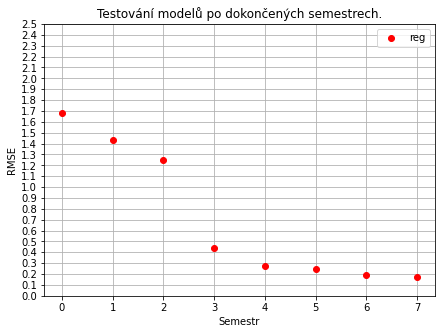

In [70]:
plt.figure(figsize=(7,5))
plt.grid(True)

xreg = results_reg['reg'].index
yreg = results_reg['reg'].values

y_values = np.arange(0.0, 2.55, 0.1)

plt.plot(xreg, yreg, 'o', color='r', label='reg')

plt.title('Testování modelů po dokončených semestrech.')

plt.yticks(y_values)
plt.xlabel('Semestr')
plt.ylabel('RMSE')

plt.legend()

plt.show()

In [71]:
results_reg

reg
0  1.684
1  1.432
2  1.249
3  0.442
4  0.274
5  0.245
6  0.187
7  0.174

#### Doplněno průměrem

In [72]:
x_test_mean = {0:Xtest_0_mean, 1:Xtest_1_mean, 2:Xtest_2_mean, 3:Xtest_3_mean, 4:Xtest_4_mean, 5:Xtest_5_mean, 6:Xtest_6_mean, 7:Xtest}
for i in range(0, 8):
    results_reg_mean.loc[i, 'reg'] = round(np.sqrt(mean_squared_error(reg.predict(x_test_mean[i]), np.array(ytest))), 3)

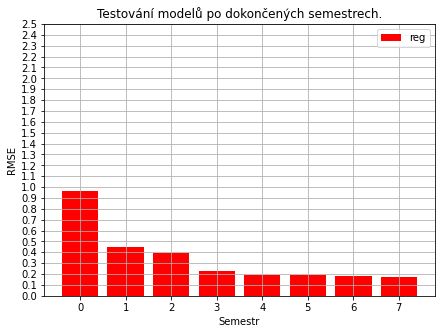

In [73]:
plt.figure(figsize=(7,5))
plt.grid(True)

xreg = results_reg_mean['reg'].index
yreg = results_reg_mean['reg'].values

y_values = np.arange(0.0, 2.55, 0.1)

plt.bar(xreg, yreg, color='r', label='reg')

plt.title('Testování modelů po dokončených semestrech.')

plt.yticks(y_values)
plt.xlabel('Semestr')
plt.ylabel('RMSE')

plt.legend()

plt.show()

In [74]:
results_reg_mean

reg
0  0.966
1  0.448
2  0.395
3  0.225
4  0.193
5   0.19
6  0.181
7  0.174

## Ostatní modely
### Měřeno accuracy_score

In [75]:
x_test = {0:Xtest_0, 1:Xtest_1, 2:Xtest_2, 3:Xtest_3, 4:Xtest_4, 5:Xtest_5, 6:Xtest_6, 7:Xtest}
for i in range(0, 8):
    results.loc[i, 'dt'] = round(metrics.accuracy_score(ytest, dt_f1.predict(x_test[i])), 3)
    results.loc[i, 'rf'] = round(metrics.accuracy_score(ytest, rf_f1.predict(x_test[i])), 3)
    results.loc[i, 'svm'] = round(metrics.accuracy_score(ytest, svc_f1.predict(x_test[i])), 3)
    results.loc[i, 'ab'] = round(metrics.accuracy_score(ytest, ab_f1.predict(x_test[i])), 3)
    results.loc[i, 'xgb'] = round(metrics.accuracy_score(ytest, xgb_f1.predict(x_test[i])), 3)
    results.loc[i, 'mlp'] = round(metrics.accuracy_score(ytest, mlp.predict(x_test[i])), 3)
    results.loc[i, 'knn'] = round(metrics.accuracy_score(ytest, knn.predict(x_test[i])), 3)

In [76]:
x_test_mean = {0:Xtest_0_mean, 1:Xtest_1_mean, 2:Xtest_2_mean, 3:Xtest_3_mean, 4:Xtest_4_mean, 5:Xtest_5_mean, 6:Xtest_6_mean, 7:Xtest}
for i in range(0, 8):
    results_mean.loc[i, 'dt'] = round(metrics.accuracy_score(ytest, dt_f1.predict(x_test_mean[i])), 3)
    results_mean.loc[i, 'rf'] = round(metrics.accuracy_score(ytest, rf_f1.predict(x_test_mean[i])), 3)
    results_mean.loc[i, 'svm'] = round(metrics.accuracy_score(ytest, svc_f1.predict(x_test_mean[i])), 3)
    results_mean.loc[i, 'ab'] = round(metrics.accuracy_score(ytest, ab_f1.predict(x_test_mean[i])), 3)
    results_mean.loc[i, 'xgb'] = round(metrics.accuracy_score(ytest, xgb_f1.predict(x_test_mean[i])), 3)
    results_mean.loc[i, 'mlp'] = round(metrics.accuracy_score(ytest, mlp.predict(x_test_mean[i])), 3)
    results_mean.loc[i, 'knn'] = round(metrics.accuracy_score(ytest, knn.predict(x_test_mean[i])), 3)

#### Po doplnění 0

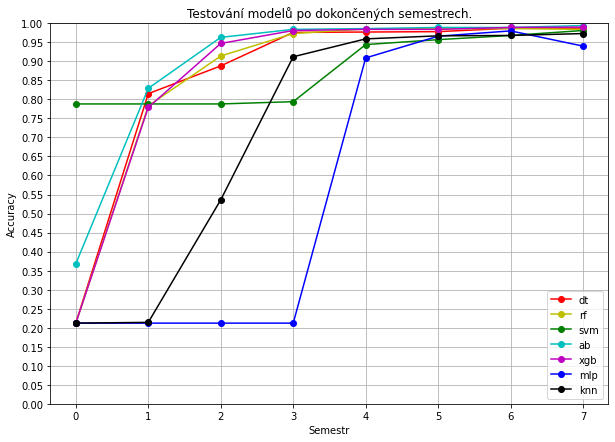

In [77]:
plt.figure(figsize=(10,7))
plt.grid(True)

xdt = results['dt'].index
ydt = results['dt'].values

xrf = results['rf'].index
yrf = results['rf'].values

xsvm = results['svm'].index
ysvm = results['svm'].values

xab = results['ab'].index
yab = results['ab'].values

xxgb = results['xgb'].index
yxgb = results['xgb'].values

xmlp = results['mlp'].index
ymlp = results['mlp'].values

xknn = results['knn'].index
yknn = results['knn'].values

y_values = np.arange(0.0, 1.05, 0.05)

plt.plot(xdt, ydt, '-o', color='r', label='dt')
plt.plot(xrf, yrf, '-o', color='y', label='rf')
plt.plot(xsvm, ysvm, '-o', color='g', label='svm')
plt.plot(xab, yab, '-o', color='c', label='ab')
plt.plot(xxgb, yxgb, '-o', color='m', label='xgb')
plt.plot(xmlp, ymlp, '-o', color='b', label='mlp')
plt.plot(xknn, yknn, '-o', color='k', label='knn')


plt.title('Testování modelů po dokončených semestrech.')

plt.yticks(y_values)
plt.xlabel('Semestr')
plt.ylabel('Accuracy')

plt.legend()

plt.ylim(ymin=0)
plt.ylim(ymax=1)

plt.show()

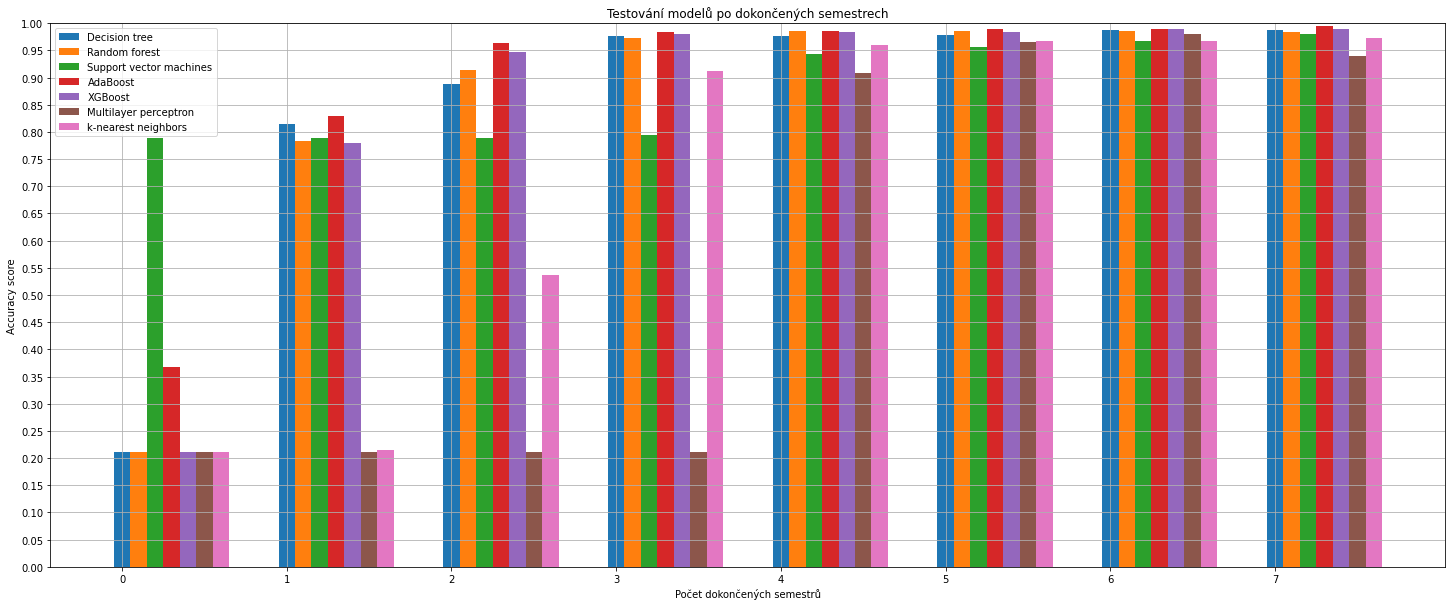

In [78]:
labels = np.array(results.index)

ydt = results['dt'].values

yrf = results['rf'].values

ysvm = results['svm'].values

yab = results['ab'].values

yxgb = results['xgb'].values

ymlp = results['mlp'].values

yknn = results['knn'].values

x = np.arange(len(labels))*2  # the label locations
width = 0.2  # the width of the bars


fig, ax = plt.subplots()
rects_dt = ax.bar(x , ydt, width, label='Decision tree')
rects_rf = ax.bar(x + width, yrf, width, label='Random forest')
rects_svm = ax.bar(x + width * 2, ysvm, width, label='Support vector machines')
rects_ab = ax.bar(x + width * 3, yab, width, label='AdaBoost')
rects_xgb = ax.bar(x + width * 4, yxgb, width, label='XGBoost')
rects_mlp = ax.bar(x + width * 5, ymlp, width, label='Multilayer perceptron')
rects_knn = ax.bar(x + width * 6, yknn, width, label='k-nearest neighbors')

y_values = np.arange(0.0, 1.05, 0.05)

ax.set_ylabel('Accuracy score')
ax.set_xlabel('Počet dokončených semestrů')
ax.set_title('Testování modelů po dokončených semestrech')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.yticks(y_values)
ax.legend(loc='best')
ax.grid(True)

plt.ylim(ymin=0)
plt.ylim(ymax=1)

fig.set_size_inches(25,10)
plt.show()

In [79]:
results

dt     rf    svm     ab    xgb    mlp    knn
0  0.212  0.212  0.788  0.368  0.212  0.212  0.212
1  0.815  0.783  0.788  0.829  0.779  0.212  0.214
2  0.888  0.914  0.788  0.963  0.947  0.212  0.536
3  0.976  0.973  0.794  0.984  0.981  0.212  0.912
4  0.977  0.985  0.944  0.986  0.984  0.909  0.959
5  0.978  0.986  0.957  0.989  0.984  0.966  0.967
6  0.987  0.986  0.968  0.989  0.989   0.98  0.968
7  0.987  0.984  0.981  0.994   0.99   0.94  0.973

#### Po doplněni průměrem

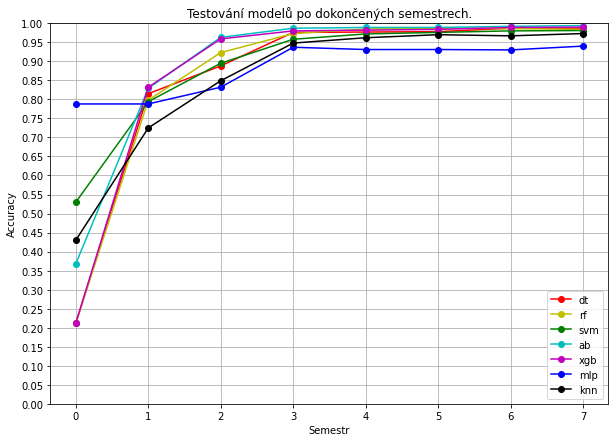

In [80]:
plt.figure(figsize=(10,7))
plt.grid(True)

xdt = results_mean['dt'].index
ydt = results_mean['dt'].values

xrf = results_mean['rf'].index
yrf = results_mean['rf'].values

xsvm = results_mean['svm'].index
ysvm = results_mean['svm'].values

xab = results_mean['ab'].index
yab = results_mean['ab'].values

xxgb = results_mean['xgb'].index
yxgb = results_mean['xgb'].values

xmlp = results_mean['mlp'].index
ymlp = results_mean['mlp'].values

xknn = results_mean['knn'].index
yknn = results_mean['knn'].values

y_values = np.arange(0.0, 1.05, 0.05)

plt.plot(xdt, ydt, '-o', color='r', label='dt')
plt.plot(xrf, yrf, '-o', color='y', label='rf')
plt.plot(xsvm, ysvm, '-o', color='g', label='svm')
plt.plot(xab, yab, '-o', color='c', label='ab')
plt.plot(xxgb, yxgb, '-o', color='m', label='xgb')
plt.plot(xmlp, ymlp, '-o', color='b', label='mlp')
plt.plot(xknn, yknn, '-o', color='k', label='knn')

plt.title('Testování modelů po dokončených semestrech.')

plt.yticks(y_values)
plt.xlabel('Semestr')
plt.ylabel('Accuracy')

plt.legend()

plt.ylim(ymin=0)
plt.ylim(ymax=1)

plt.show()

In [81]:
results_mean

dt     rf    svm     ab    xgb    mlp    knn
0  0.212  0.212   0.53  0.368  0.212  0.788   0.43
1  0.815  0.798  0.794  0.829  0.832  0.788  0.725
2  0.888  0.923  0.895  0.963  0.959  0.832  0.849
3  0.976  0.973  0.958  0.987   0.98  0.937  0.948
4  0.977  0.985  0.972  0.989  0.982  0.931  0.962
5  0.978  0.987  0.976  0.989  0.984  0.931   0.97
6  0.987  0.986   0.98  0.992  0.989   0.93  0.967
7  0.987  0.984  0.981  0.994   0.99   0.94  0.973

### Měřeno f1_score

In [82]:
x_test = {0:Xtest_0, 1:Xtest_1, 2:Xtest_2, 3:Xtest_3, 4:Xtest_4, 5:Xtest_5, 6:Xtest_6, 7:Xtest}
for i in range(0, 8):
    results_f1.loc[i, 'dt'] = round(metrics.f1_score(ytest, dt_f1.predict(x_test[i])), 3)
    results_f1.loc[i, 'rf'] = round(metrics.f1_score(ytest, rf_f1.predict(x_test[i])), 3)
    results_f1.loc[i, 'svm'] = round(metrics.f1_score(ytest, svc_f1.predict(x_test[i])), 3)
    results_f1.loc[i, 'ab'] = round(metrics.f1_score(ytest, ab_f1.predict(x_test[i])), 3)
    results_f1.loc[i, 'xgb'] = round(metrics.f1_score(ytest, xgb_f1.predict(x_test[i])), 3)
    results_f1.loc[i, 'mlp'] = round(metrics.f1_score(ytest, mlp.predict(x_test[i])), 3)
    results_f1.loc[i, 'knn'] = round(metrics.f1_score(ytest, knn.predict(x_test[i])), 3)

In [83]:
x_test_mean = {0:Xtest_0_mean, 1:Xtest_1_mean, 2:Xtest_2_mean, 3:Xtest_3_mean, 4:Xtest_4_mean, 5:Xtest_5_mean, 6:Xtest_6_mean, 7:Xtest}
for i in range(0, 8):
    results_mean_f1.loc[i, 'dt'] = round(metrics.f1_score(ytest, dt_f1.predict(x_test_mean[i])), 3)
    results_mean_f1.loc[i, 'rf'] = round(metrics.f1_score(ytest, rf_f1.predict(x_test_mean[i])), 3)
    results_mean_f1.loc[i, 'svm'] = round(metrics.f1_score(ytest, svc_f1.predict(x_test_mean[i])), 3)
    results_mean_f1.loc[i, 'ab'] = round(metrics.f1_score(ytest, ab_f1.predict(x_test_mean[i])), 3)
    results_mean_f1.loc[i, 'xgb'] = round(metrics.f1_score(ytest, xgb_f1.predict(x_test_mean[i])), 3)
    results_mean_f1.loc[i, 'mlp'] = round(metrics.f1_score(ytest, mlp.predict(x_test[i])), 3)
    results_mean_f1.loc[i, 'knn'] = round(metrics.f1_score(ytest, knn.predict(x_test[i])), 3)

#### Po doplnění 0

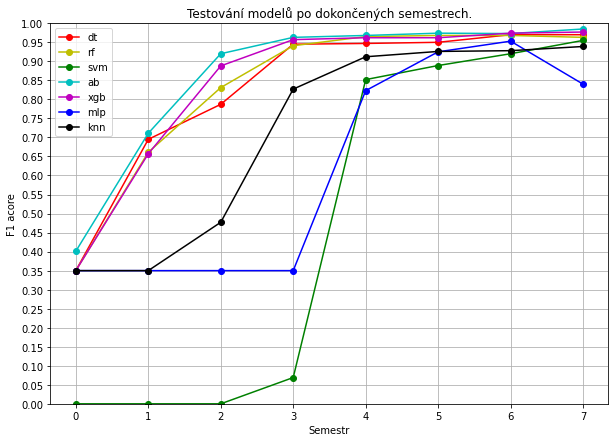

In [84]:
plt.figure(figsize=(10,7))
plt.grid(True)

xdt = results_f1['dt'].index
ydt = results_f1['dt'].values

xrf = results_f1['rf'].index
yrf = results_f1['rf'].values

xsvm = results_f1['svm'].index
ysvm = results_f1['svm'].values

xab = results_f1['ab'].index
yab = results_f1['ab'].values

xxgb = results_f1['xgb'].index
yxgb = results_f1['xgb'].values

xmlp = results_f1['mlp'].index
ymlp = results_f1['mlp'].values

xknn = results_f1['knn'].index
yknn = results_f1['knn'].values

y_values = np.arange(0.0, 1.05, 0.05)

plt.plot(xdt, ydt, '-o', color='r', label='dt')
plt.plot(xrf, yrf, '-o', color='y', label='rf')
plt.plot(xsvm, ysvm, '-o', color='g', label='svm')
plt.plot(xab, yab, '-o', color='c', label='ab')
plt.plot(xxgb, yxgb, '-o', color='m', label='xgb')
plt.plot(xmlp, ymlp, '-o', color='b', label='mlp')
plt.plot(xknn, yknn, '-o', color='k', label='knn')


plt.title('Testování modelů po dokončených semestrech.')

plt.yticks(y_values)
plt.xlabel('Semestr')
plt.ylabel('F1 acore')

plt.legend()

plt.ylim(ymin=0)
plt.ylim(ymax=1)

plt.show()

In [85]:
results_f1

dt     rf    svm     ab    xgb    mlp    knn
0   0.35   0.35      0  0.401   0.35   0.35   0.35
1  0.695  0.661      0  0.711  0.657   0.35   0.35
2  0.787  0.831      0   0.92  0.888   0.35  0.477
3  0.945  0.941  0.069  0.963  0.957   0.35  0.827
4  0.947  0.965  0.852  0.968  0.962  0.823  0.912
5   0.95  0.968  0.889  0.974  0.962  0.925  0.926
6   0.97  0.968   0.92  0.973  0.974  0.953  0.928
7   0.97  0.963  0.955  0.985  0.977   0.84  0.939

#### Po doplněni průměrem

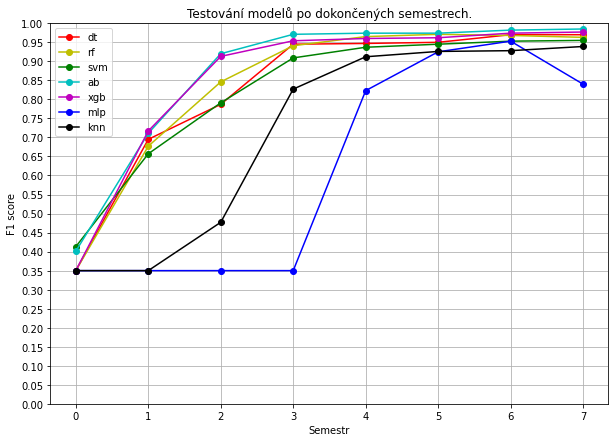

In [86]:
plt.figure(figsize=(10,7))
plt.grid(True)

xdt = results_mean_f1['dt'].index
ydt = results_mean_f1['dt'].values

xrf = results_mean_f1['rf'].index
yrf = results_mean_f1['rf'].values

xsvm = results_mean_f1['svm'].index
ysvm = results_mean_f1['svm'].values

xab = results_mean_f1['ab'].index
yab = results_mean_f1['ab'].values

xxgb = results_mean_f1['xgb'].index
yxgb = results_mean_f1['xgb'].values

xmlp = results_mean_f1['mlp'].index
ymlp = results_mean_f1['mlp'].values

xknn = results_mean_f1['knn'].index
yknn = results_mean_f1['knn'].values

y_values = np.arange(0.0, 1.05, 0.05)

plt.plot(xdt, ydt, '-o', color='r', label='dt')
plt.plot(xrf, yrf, '-o', color='y', label='rf')
plt.plot(xsvm, ysvm, '-o', color='g', label='svm')
plt.plot(xab, yab, '-o', color='c', label='ab')
plt.plot(xxgb, yxgb, '-o', color='m', label='xgb')
plt.plot(xmlp, ymlp, '-o', color='b', label='mlp')
plt.plot(xknn, yknn, '-o', color='k', label='knn')


plt.title('Testování modelů po dokončených semestrech.')

plt.yticks(y_values)
plt.xlabel('Semestr')
plt.ylabel('F1 score')

plt.legend()

plt.ylim(ymin=0)
plt.ylim(ymax=1)

plt.show()

In [87]:
results_mean_f1

dt     rf    svm     ab    xgb    mlp    knn
0   0.35   0.35  0.413  0.401   0.35   0.35   0.35
1  0.695  0.677  0.657  0.711  0.717   0.35   0.35
2  0.787  0.846  0.791   0.92  0.913   0.35  0.477
3  0.945  0.941  0.909  0.971  0.954   0.35  0.827
4  0.947  0.965  0.937  0.974   0.96  0.823  0.912
5   0.95  0.971  0.945  0.974  0.962  0.925  0.926
6   0.97  0.968  0.953  0.982  0.974  0.953  0.928
7   0.97  0.963  0.955  0.985  0.977   0.84  0.939